# Walmart Store Sales Forecasting Dataset

### Getting started

#### Importing...

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

#### Load Dataset

In [2]:
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

# Convert date columns
train['Date'] = pd.to_datetime(train['Date'], errors='coerce')
features['Date'] = pd.to_datetime(features['Date'], errors='coerce')
# convert before merge to avoid data mismatch: for example 11-11-1111 : 11/11/1111

# Merge datasets
df = train.merge(features, on=['Store', 'Date'], how='left')
df = df.merge(stores, on='Store', how='left')

# # Handle missing values
# df.loc[['CPI','Fuel_Price']]fillna(method='ffill', inplace=True)
# # ffill: Forward Fill: Fills missing values by copying the last known value forward.
# #Why use it here? Economic indicators like CPI or fuel price don’t change daily. Forward fill assumes the last value is still valid until updated.

# Create new features
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
# Helps with filtering data and with groupby

df.head()
# Normalize holiday flag
df['IsHoliday_y'] = df['IsHoliday_y'].astype(int)
# Converts value from bool to int which makes it easier to use in numeric operations, visualizations, or machine learning models.

# merging error => fix:
df['IsHoliday'] = df['IsHoliday_y']  # or 'IsHoliday_x'
df.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)

### Have a look on the data

In [3]:
df.head()

Store  Dept       Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2010-02-05      24924.50        42.31       2.572        NaN   
1      1     1 2010-02-12      46039.49        38.51       2.548        NaN   
2      1     1 2010-02-19      41595.55        39.93       2.514        NaN   
3      1     1 2010-02-26      19403.54        46.63       2.561        NaN   
4      1     1 2010-03-05      21827.90        46.50       2.625        NaN   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0        NaN        NaN        NaN        NaN  211.096358         8.106    A   
1        NaN        NaN        NaN        NaN  211.242170         8.106    A   
2        NaN        NaN        NaN        NaN  211.289143         8.106    A   
3        NaN        NaN        NaN        NaN  211.319643         8.106    A   
4        NaN        NaN        NaN        NaN  211.350143         8.106    A   

     Size  Month  Year  Week  IsHoliday  
0  151315      2  2010     5          0  
1  151315      2  2010     6          1  
2  151315      2  2010     7          0  
3  151315      2  2010     8          0  
4  151315      3  2010     9          0

**Store**	Store ID

**Dept**	Department number	Each store has multiple departments.

**Date**	Week-ending date

**Weekly_Sales**	Sales for that store-department-week

**Temperature**	Average temperature that week (local)	External factor.

**Fuel_Price**	Local fuel price	Economic indicator.

MarkDown1–5	Promotional markdowns (discounts)	Represent different types of
promotions.

**CPI**	Consumer Price Index	Macro-economic indicator.

**Unemployment**	Local unemployment rate	Another economic indicator. Higher unemployment may reduce sales.

**Type**	Store type (A, B, C)	Categorical feature. Larger stores (Type A) may have higher sales.

**Size**	Store size in square feet	Numeric feature. Bigger stores → more capacity, potentially higher sales.

**Month**	Extracted from Date,
**Year**	Extracted from Date,	Useful for trend analysis across years.
**Week**	ISO week number	Captures weekly seasonality. Important for aligning across years.

**IsHoliday**	Binary flag (1 = holiday week, 0 = non-holiday)	Critical feature. Sales spike during holidays. Must be handled carefully in forecasting.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70562 entries, 0 to 70561
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         70562 non-null  int64         
 1   Dept          70562 non-null  int64         
 2   Date          70562 non-null  datetime64[ns]
 3   Weekly_Sales  70562 non-null  float64       
 4   Temperature   70562 non-null  float64       
 5   Fuel_Price    70562 non-null  float64       
 6   MarkDown1     25234 non-null  float64       
 7   MarkDown2     20168 non-null  float64       
 8   MarkDown3     23702 non-null  float64       
 9   MarkDown4     24889 non-null  float64       
 10  MarkDown5     25234 non-null  float64       
 11  CPI           70562 non-null  float64       
 12  Unemployment  70562 non-null  float64       
 13  Type          70562 non-null  object        
 14  Size          70562 non-null  int64         
 15  Month         70562 non-null  int32 

In [5]:
df.describe(exclude=['datetime64','UInt32','int32'])

Store          Dept   Weekly_Sales   Temperature    Fuel_Price  \
count   70562.000000  70562.000000   70562.000000  70562.000000  70562.000000   
unique           NaN           NaN            NaN           NaN           NaN   
top              NaN           NaN            NaN           NaN           NaN   
freq             NaN           NaN            NaN           NaN           NaN   
mean        4.080256     42.640529   17544.341381     63.945482      3.221950   
std         2.090044     30.000829   25757.966720     17.994359      0.424626   
min         1.000000      1.000000   -1098.000000     -2.060000      2.514000   
25%         2.000000     17.000000    2342.882500     51.180000      2.762000   
50%         4.000000     35.000000    7736.345000     66.270000      3.290000   
75%         6.000000     71.000000   21096.477500     79.510000      3.594000   
max         8.000000     99.000000  385051.040000     93.340000      3.936000   

           MarkDown1     MarkDown2     MarkDown3     MarkDown4     MarkDown5  \
count   25234.000000  20168.000000  23702.000000  24889.000000  25234.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean     7149.519581   3131.169255   1390.203850   3100.085951   4609.190925   
std      7968.284121  10185.186824   9053.365668   5509.648471   5134.316867   
min        35.940000    -10.980000      0.010000      4.000000    135.160000   
25%      2565.800000     30.000000      4.590000    444.640000   1790.310000   
50%      5183.290000    151.000000     21.980000   1282.300000   3558.180000   
75%      8813.810000   1555.570000     98.670000   3639.420000   5715.690000   
max     75149.790000  92523.940000  83340.330000  48159.860000  58068.140000   

                 CPI  Unemployment   Type           Size     IsHoliday  
count   70562.000000  70562.000000  70562   70562.000000  70562.000000  
unique           NaN           NaN      2            NaN           NaN  
top              NaN           NaN      A            NaN           NaN  
freq             NaN           NaN  42765            NaN           NaN  
mean      200.967795      7.100792    NaN  133568.325161      0.070619  
std        31.155787      1.093684    NaN   71868.085398      0.256189  
min       126.064000      3.879000    NaN   34875.000000      0.000000  
25%       196.951558      6.496000    NaN   37392.000000      0.000000  
50%       213.667086      7.143000    NaN  151315.000000      0.000000  
75%       219.237049      7.872000    NaN  202505.000000      0.000000  
max       227.036936      9.137000    NaN  205863.000000      1.000000

In [6]:
df.loc[:,['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment']].describe()

Weekly_Sales   Temperature    Fuel_Price           CPI  Unemployment
count   70562.000000  70562.000000  70562.000000  70562.000000  70562.000000
mean    17544.341381     63.945482      3.221950    200.967795      7.100792
std     25757.966720     17.994359      0.424626     31.155787      1.093684
min     -1098.000000     -2.060000      2.514000    126.064000      3.879000
25%      2342.882500     51.180000      2.762000    196.951558      6.496000
50%      7736.345000     66.270000      3.290000    213.667086      7.143000
75%     21096.477500     79.510000      3.594000    219.237049      7.872000
max    385051.040000     93.340000      3.936000    227.036936      9.137000

Weekly_Sales has a high std; that means data has outliers

In [7]:
df.isna().sum()

Store               0
Dept                0
Date                0
Weekly_Sales        0
Temperature         0
Fuel_Price          0
MarkDown1       45328
MarkDown2       50394
MarkDown3       46860
MarkDown4       45673
MarkDown5       45328
CPI                 0
Unemployment        0
Type                0
Size                0
Month               0
Year                0
Week                0
IsHoliday           0
dtype: int64

We have a lot missing values in markDowns

In [8]:
df.nunique()

Store               8
Dept               78
Date              143
Weekly_Sales    66487
Temperature      1043
Fuel_Price        357
MarkDown1         408
MarkDown2         307
MarkDown3         353
MarkDown4         400
MarkDown5         408
CPI              1144
Unemployment       96
Type                2
Size                8
Month              12
Year                3
Week               52
IsHoliday           2
dtype: int64

I can see that we are dealing with **45** stores, **81** department, **3** store types, and **3** years.

In [9]:
df['Date'].agg(['min','max'])

min   2010-02-05
max   2012-10-26
Name: Date, dtype: datetime64[ns]

The sales starts at 5 Feb 2010 till 26 Oct 2012 that almost 3 years.

In [10]:
df.groupby('Store').size().sort_values(ascending=False)

Store
4    10272
1    10244
2    10238
6    10211
7     9762
3     9036
5     8999
8     1800
dtype: int64

We can say that store 13 has the most sales operations unlike 36 which has the least.

In [11]:
df.groupby('Dept').size().sort_values(ascending=False)

Dept
1     1144
2     1144
3     1144
4     1144
5     1144
      ... 
99     162
47     110
78      34
77      23
39       5
Length: 78, dtype: int64

We can say that department 1 has the most sales operations unlike 43 which has the least.

In [12]:
summary = pd.DataFrame({
    "dtype": df.dtypes,
    "unique_values": df.nunique(),
    "missing_values": df.isna().sum(),
    "total_rows": len(df)
})

summary["missing_pct"] = (summary["missing_values"] / summary["total_rows"]) * 100
summary

dtype  unique_values  missing_values  total_rows  \
Store                  int64              8               0       70562   
Dept                   int64             78               0       70562   
Date          datetime64[ns]            143               0       70562   
Weekly_Sales         float64          66487               0       70562   
Temperature          float64           1043               0       70562   
Fuel_Price           float64            357               0       70562   
MarkDown1            float64            408           45328       70562   
MarkDown2            float64            307           50394       70562   
MarkDown3            float64            353           46860       70562   
MarkDown4            float64            400           45673       70562   
MarkDown5            float64            408           45328       70562   
CPI                  float64           1144               0       70562   
Unemployment         float64             96               0       70562   
Type                  object              2               0       70562   
Size                   int64              8               0       70562   
Month                  int32             12               0       70562   
Year                   int32              3               0       70562   
Week                  UInt32             52               0       70562   
IsHoliday              int64              2               0       70562   

              missing_pct  
Store            0.000000  
Dept             0.000000  
Date             0.000000  
Weekly_Sales     0.000000  
Temperature      0.000000  
Fuel_Price       0.000000  
MarkDown1       64.238542  
MarkDown2       71.418044  
MarkDown3       66.409682  
MarkDown4       64.727474  
MarkDown5       64.238542  
CPI              0.000000  
Unemployment     0.000000  
Type             0.000000  
Size             0.000000  
Month            0.000000  
Year             0.000000  
Week             0.000000  
IsHoliday        0.000000

In [13]:
df.groupby('Store')['Dept'].nunique()

Store
1    77
2    78
3    72
4    78
5    72
6    77
7    76
8    13
Name: Dept, dtype: int64

All stores has 60-80 department

### Fix, validate, and clean data

In [14]:
# markdowns is a different promotional strategies Walmart used during the dataset period.
#Each MarkDown column is a numeric value (dollar amount) representing discounts or promotions applied to products in a given week.
df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = \
    df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

df['Total_MarkDown'] = df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum(axis=1)

summary

dtype  unique_values  missing_values  total_rows  \
Store                  int64              8               0       70562   
Dept                   int64             78               0       70562   
Date          datetime64[ns]            143               0       70562   
Weekly_Sales         float64          66487               0       70562   
Temperature          float64           1043               0       70562   
Fuel_Price           float64            357               0       70562   
MarkDown1            float64            408           45328       70562   
MarkDown2            float64            307           50394       70562   
MarkDown3            float64            353           46860       70562   
MarkDown4            float64            400           45673       70562   
MarkDown5            float64            408           45328       70562   
CPI                  float64           1144               0       70562   
Unemployment         float64             96               0       70562   
Type                  object              2               0       70562   
Size                   int64              8               0       70562   
Month                  int32             12               0       70562   
Year                   int32              3               0       70562   
Week                  UInt32             52               0       70562   
IsHoliday              int64              2               0       70562   

              missing_pct  
Store            0.000000  
Dept             0.000000  
Date             0.000000  
Weekly_Sales     0.000000  
Temperature      0.000000  
Fuel_Price       0.000000  
MarkDown1       64.238542  
MarkDown2       71.418044  
MarkDown3       66.409682  
MarkDown4       64.727474  
MarkDown5       64.238542  
CPI              0.000000  
Unemployment     0.000000  
Type             0.000000  
Size             0.000000  
Month            0.000000  
Year             0.000000  
Week             0.000000  
IsHoliday        0.000000

## Understanding data more

In [15]:
df.head(10)

Store  Dept       Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2010-02-05      24924.50        42.31       2.572        0.0   
1      1     1 2010-02-12      46039.49        38.51       2.548        0.0   
2      1     1 2010-02-19      41595.55        39.93       2.514        0.0   
3      1     1 2010-02-26      19403.54        46.63       2.561        0.0   
4      1     1 2010-03-05      21827.90        46.50       2.625        0.0   
5      1     1 2010-03-12      21043.39        57.79       2.667        0.0   
6      1     1 2010-03-19      22136.64        54.58       2.720        0.0   
7      1     1 2010-03-26      26229.21        51.45       2.732        0.0   
8      1     1 2010-04-02      57258.43        62.27       2.719        0.0   
9      1     1 2010-04-09      42960.91        65.86       2.770        0.0   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment Type  \
0        0.0        0.0        0.0        0.0  211.096358         8.106    A   
1        0.0        0.0        0.0        0.0  211.242170         8.106    A   
2        0.0        0.0        0.0        0.0  211.289143         8.106    A   
3        0.0        0.0        0.0        0.0  211.319643         8.106    A   
4        0.0        0.0        0.0        0.0  211.350143         8.106    A   
5        0.0        0.0        0.0        0.0  211.380643         8.106    A   
6        0.0        0.0        0.0        0.0  211.215635         8.106    A   
7        0.0        0.0        0.0        0.0  211.018042         8.106    A   
8        0.0        0.0        0.0        0.0  210.820450         7.808    A   
9        0.0        0.0        0.0        0.0  210.622857         7.808    A   

     Size  Month  Year  Week  IsHoliday  Total_MarkDown  
0  151315      2  2010     5          0             0.0  
1  151315      2  2010     6          1             0.0  
2  151315      2  2010     7          0             0.0  
3  151315      2  2010     8          0             0.0  
4  151315      3  2010     9          0             0.0  
5  151315      3  2010    10          0             0.0  
6  151315      3  2010    11          0             0.0  
7  151315      3  2010    12          0             0.0  
8  151315      4  2010    13          0             0.0  
9  151315      4  2010    14          0             0.0

#### Dates
It's all about time honey.

In [16]:
df.groupby('Year')[['Weekly_Sales','CPI','Unemployment','Fuel_Price','Temperature','Total_MarkDown']].sum()/1e6

Weekly_Sales       CPI  Unemployment  Fuel_Price  Temperature  \
Year                                                                  
2010    411.633722  4.656823      0.181466    0.063958     1.490650   
2011    451.023076  5.158002      0.185727    0.088079     1.607193   
2012    375.307019  4.365864      0.133853    0.075310     1.414278   

      Total_MarkDown  
Year                  
2010        0.000000  
2011      108.541540  
2012      361.435833

We can see that there is a relation between this data,
MarkDowns increase makes sales decrease
Temperature, CPI, unemployment, and fuel effect sales.

In [17]:
df.groupby(['Year','Month'])[['Weekly_Sales','CPI','Unemployment','Fuel_Price','Temperature','Total_MarkDown']]\
.sum().sort_values(by='Weekly_Sales', ascending=False)

Weekly_Sales            CPI  Unemployment  Fuel_Price  \
Year Month                                                          
2011 12      53396130.96  515040.039217     17634.803    7982.019   
2010 12      52804216.52  488099.318638     18898.430    7032.091   
2012 6       45160335.47  503734.147703     15629.157    8420.725   
     3       44287083.19  507509.706514     16237.541    9124.316   
     8       44128998.06  506550.985235     15041.722    8711.900   
2011 7       42203098.24  484615.343146     17569.117    8638.891   
     4       41334364.79  493511.466301     17890.730    9068.957   
2010 7       41125902.09  478512.552038     18436.330    6445.480   
     4       40996367.46  486135.699399     18997.842    6874.563   
2011 9       40273366.69  495575.948526     17921.464    8608.820   
2010 10      39060261.12  487741.788369     18869.366    6653.315   
2011 11      38687678.01  405217.336420     13929.904    6621.956   
2010 11      37154906.21  389466.046795     15061.881    5394.381   
2012 2       36734839.88  410123.191494     13157.874    6816.310   
     7       35426442.03  403999.950277     12008.621    6542.496   
     4       35396813.68  407180.190154     12629.887    7657.707   
2011 2       35335583.12  392723.226802     14676.827    6002.941   
2010 2       35023543.17  396412.994478     15897.740    5155.198   
2012 5       34854515.42  402211.375395     12460.613    7193.220   
2011 6       34758701.05  392404.098145     14237.332    7153.081   
     8       34347549.79  392262.033600     14199.392    7001.469   
2010 6       34256682.57  383108.638405     14938.707    5200.108   
2011 3       34200567.99  396767.926569     14756.806    6799.074   
2012 10      34100939.64  410467.269116     11536.875    7131.219   
2010 8       33673097.67  383458.289257     14734.150    5183.542   
2012 9       33469048.76  408897.499918     12118.003    7331.410   
2011 10      33256490.75  402075.080873     13862.846    6652.446   
2010 3       33006320.30  393430.638925     15776.872    5380.282   
     5       32832142.47  383191.728932     14973.888    5492.915   
2011 5       32529557.86  398186.110561     14410.007    7650.276   
2012 1       31748002.88  405189.971625     13032.737    6380.842   
2010 9       31700282.18  387265.265423     14881.112    5145.965   
2011 1       30699986.53  389623.696692     14637.515    5899.346   

            Temperature  Total_MarkDown  
Year Month                               
2011 12       106005.11     60250422.75  
2010 12       112169.58            0.00  
2012 6        192505.19     34558377.65  
     3        143792.95     39596765.29  
     8        197957.03     49536130.78  
2011 7        199962.67            0.00  
     4        155483.94            0.00  
2010 7        192729.84            0.00  
     4        149659.42            0.00  
2011 9        185690.27            0.00  
2010 10       157881.19            0.00  
2011 11       107234.64     48291117.17  
2010 11       106341.04            0.00  
2012 2         92406.20     80031331.92  
     7        155557.56     30059398.22  
     4        130755.36     22052497.20  
2011 2         85749.34            0.00  
2010 2         78960.49            0.00  
2012 5        138740.78     30266979.18  
2011 6        155206.66            0.00  
     8        164571.33            0.00  
2010 6        152565.60            0.00  
2011 3        111017.23            0.00  
2012 10       127496.62     15609095.15  
2010 8        158967.63            0.00  
2012 9        145389.57     26749544.25  
2011 10       126420.28            0.00  
2010 3         99093.50            0.00  
     5        135823.43            0.00  
2011 5        133158.70            0.00  
2012 1         89676.88     32975713.77  
2010 9        146458.37            0.00  
2011 1         76692.73            0.00

The highest sales happen in December because holidays I can say.

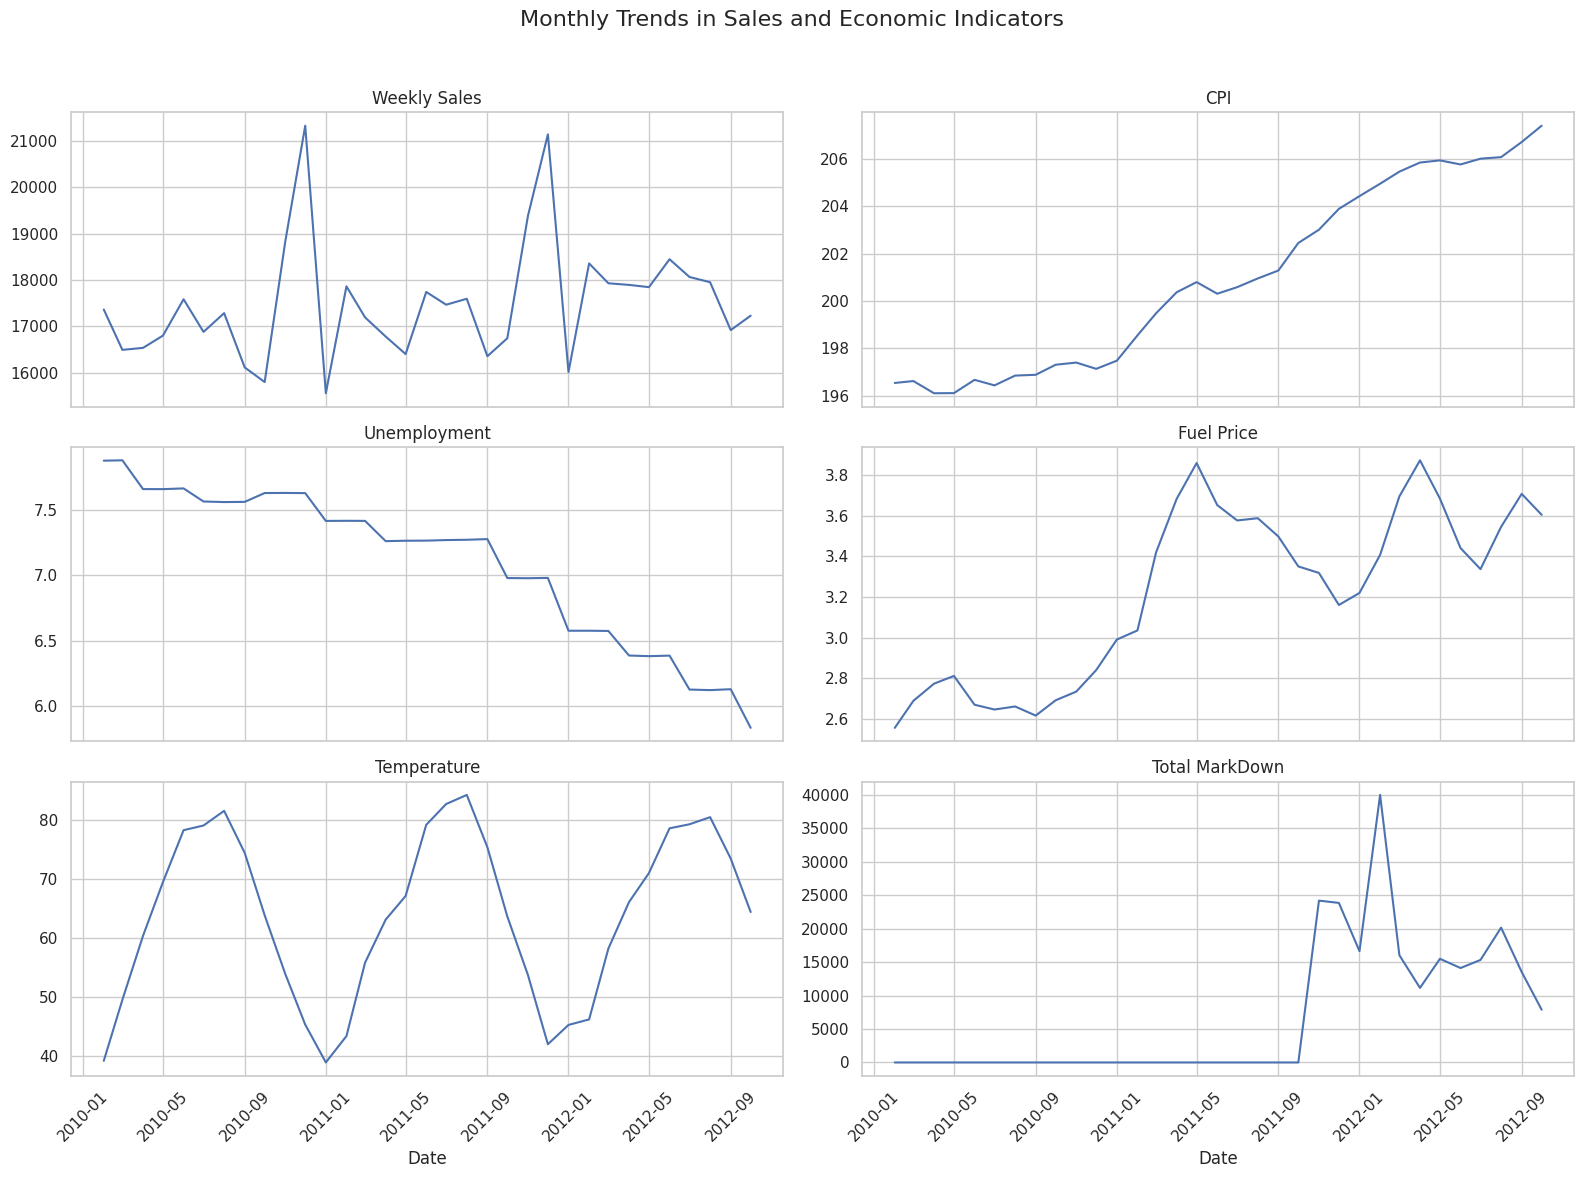

In [18]:
# Step 1: Group and aggregate
date_feature = df.groupby(['Year', 'Month'])[
    ['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown']
].mean().reset_index()

# Step 2: Create a proper datetime column
date_feature['Date'] = pd.to_datetime(date_feature[['Year', 'Month']].assign(DAY=1))

# Step 3: Set plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
fig.suptitle("Monthly Trends in Sales and Economic Indicators", fontsize=16)

# Step 4: Plot each feature
features = ['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown']
for ax, feature in zip(axes.flat, features):
    sns.lineplot(data=date_feature, x='Date', y=feature, ax=ax)
    ax.set_title(feature.replace('_', ' '))
    ax.set_ylabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The highest sales are in December which i belive because holidays, and the lowest ones in January,
MarkDowns have no relation with sales rate.
Other features need more studing.

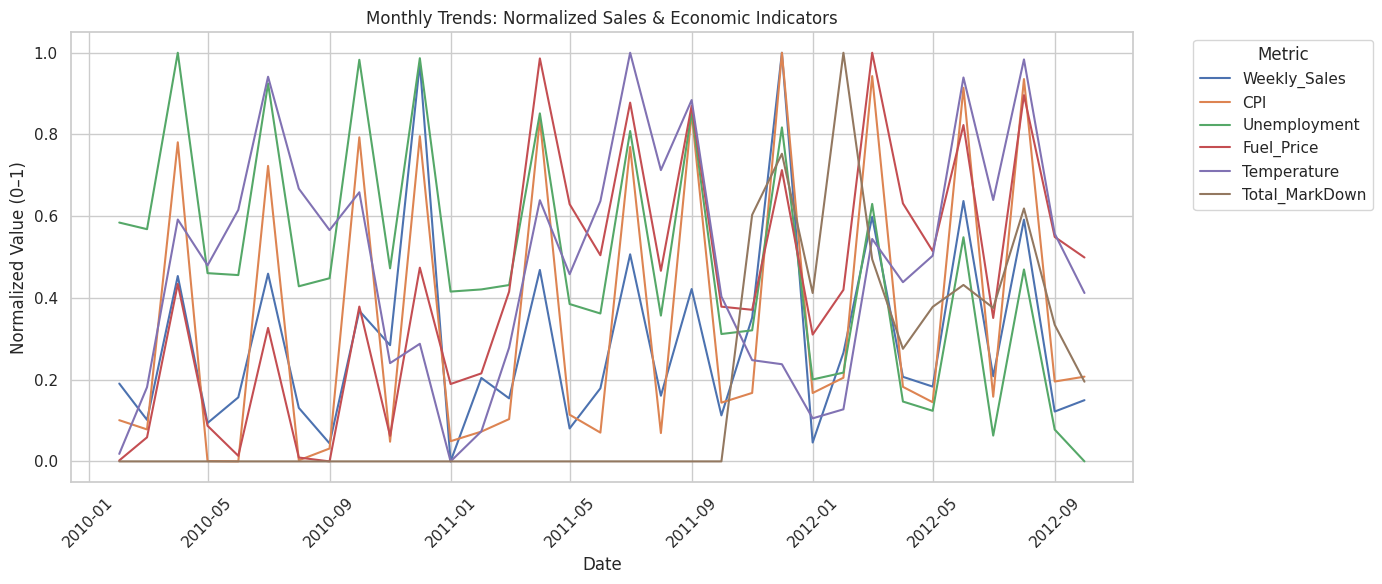

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Group and aggregate monthly data
date_feature = df.groupby(['Year', 'Month'])[
    ['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown']
].sum().reset_index()

# Step 2: Create a proper datetime column
date_feature['Date'] = pd.to_datetime(date_feature[['Year', 'Month']].assign(DAY=1))

# Step 3: Normalize all metric columns using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(date_feature[
    ['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown']
])
scaled_df = pd.DataFrame(scaled_values, columns=[
    'Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown'
])
scaled_df['Date'] = date_feature['Date']

# Step 4: Melt the DataFrame for seaborn
melted = scaled_df.melt(id_vars='Date', var_name='Metric', value_name='Value')

# Step 5: Plot all metrics on one chart
plt.figure(figsize=(14, 6))
sns.lineplot(data=melted, x='Date', y='Value', hue='Metric')
plt.title("Monthly Trends: Normalized Sales & Economic Indicators")
plt.xlabel("Date")
plt.ylabel("Normalized Value (0–1)")
plt.xticks(rotation=45)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

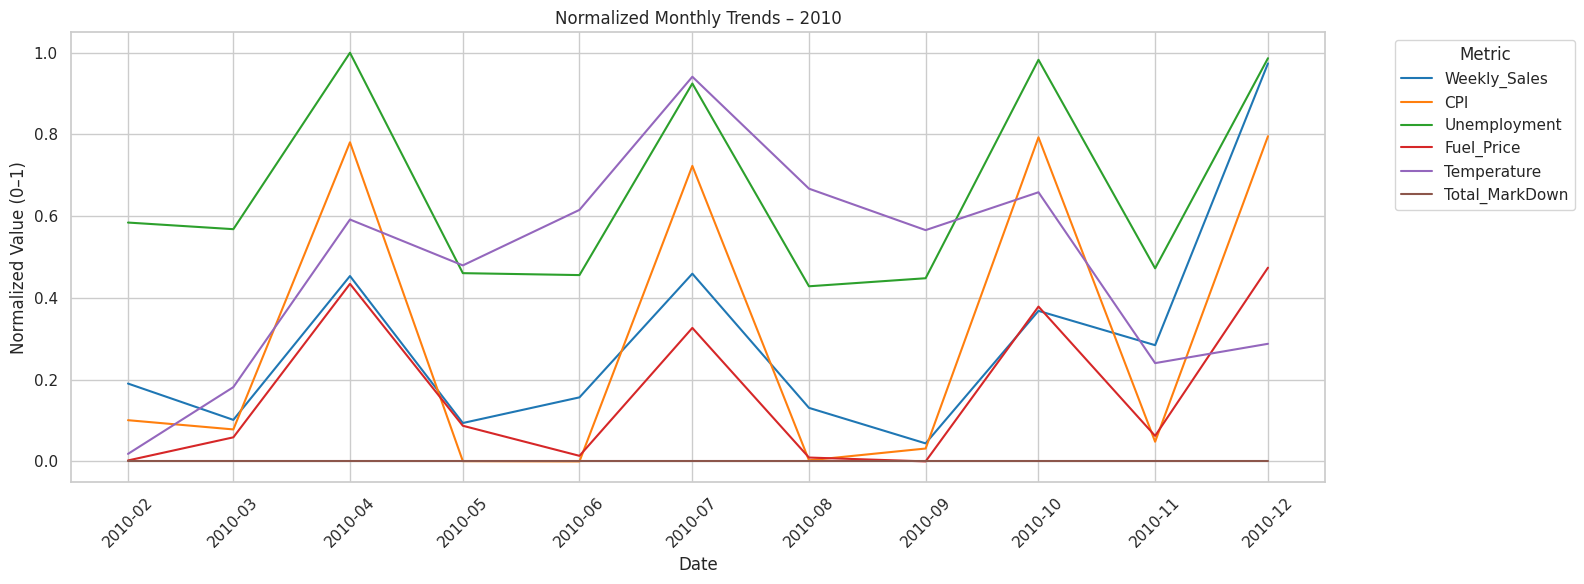

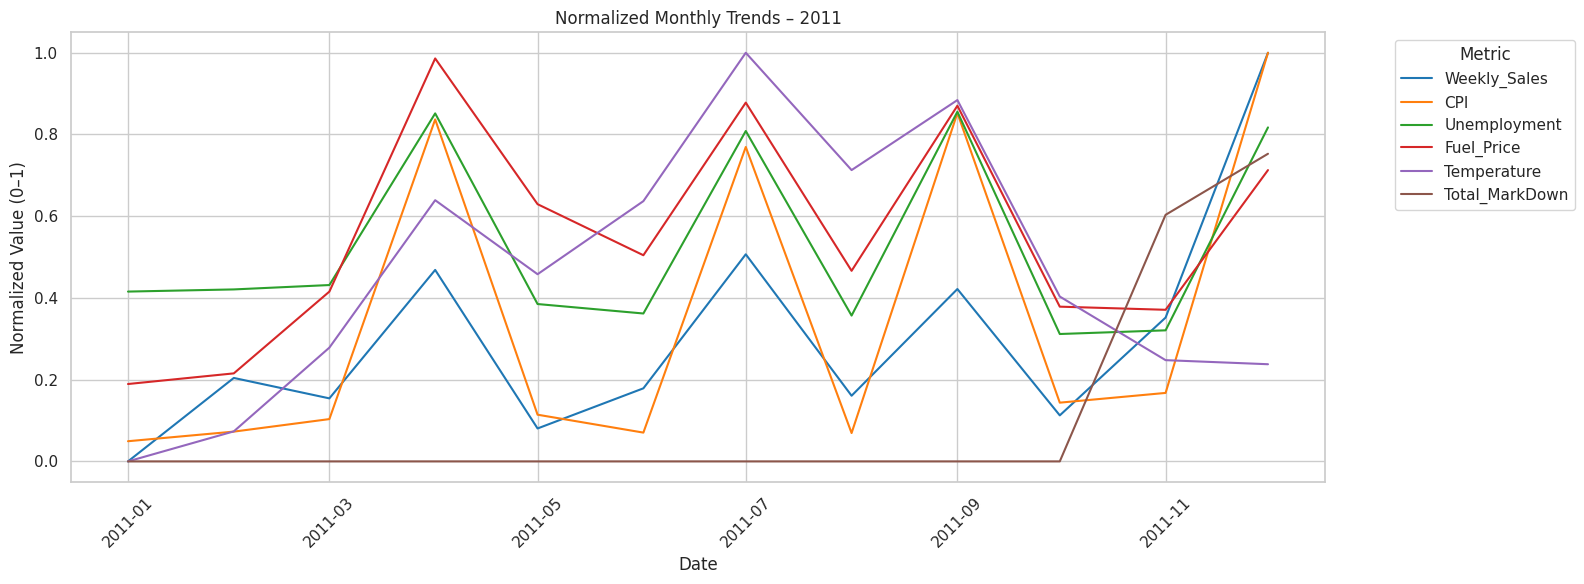

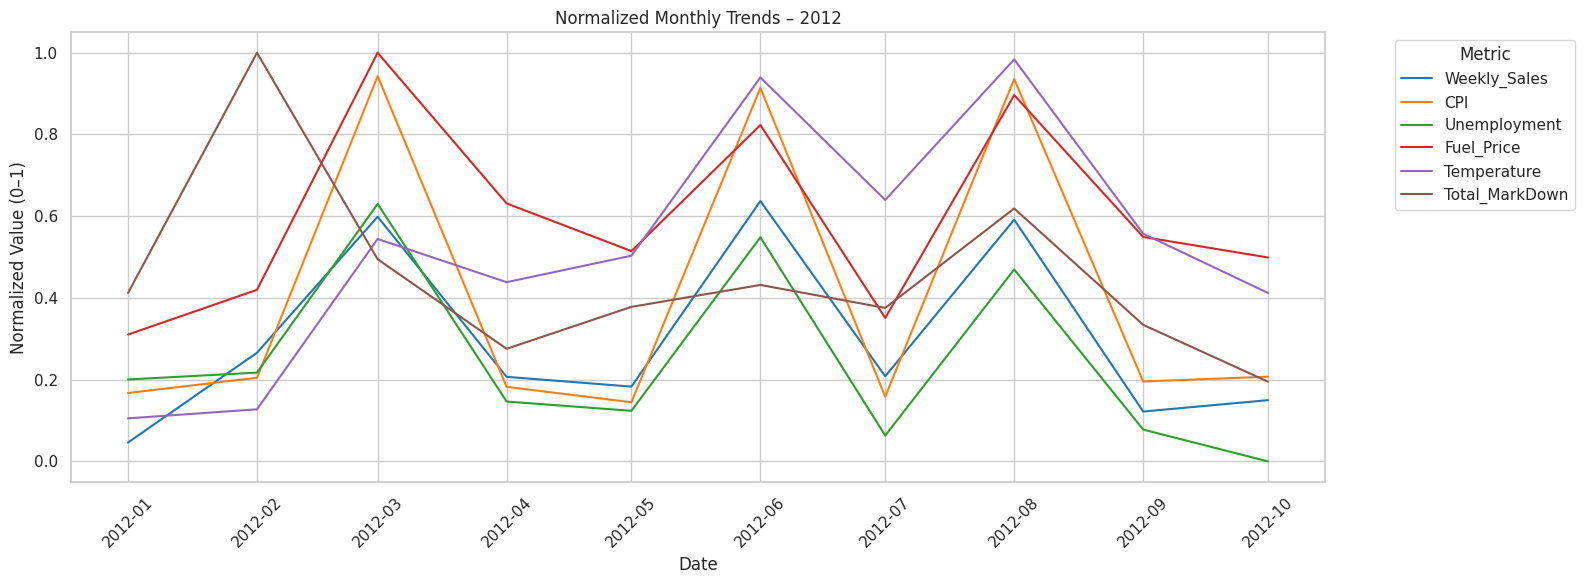

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Group and aggregate monthly data
date_feature = df.groupby(['Year', 'Month'])[
    ['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown']
].sum().reset_index()

# Step 2: Create a proper datetime column
date_feature['Date'] = pd.to_datetime(date_feature[['Year', 'Month']].assign(DAY=1))

# Step 3: Normalize all metric columns using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(date_feature[
    ['Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown']
])
scaled_df = pd.DataFrame(scaled_values, columns=[
    'Weekly_Sales', 'CPI', 'Unemployment', 'Fuel_Price', 'Temperature', 'Total_MarkDown'
])
scaled_df['Date'] = date_feature['Date']
scaled_df['Year'] = date_feature['Year']

# Step 4: Melt the DataFrame for seaborn
melted = scaled_df.melt(id_vars=['Date', 'Year'], var_name='Metric', value_name='Value')

# Step 5: Plot each year in a separate full-width figure
for year in [2010, 2011, 2012]:
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=melted[melted['Year'] == year], x='Date', y='Value', hue='Metric', palette='tab10')
    plt.title(f"Normalized Monthly Trends – {year}")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value (0–1)")
    plt.xticks(rotation=45)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


We can rely on CPI, fuel, and unemployment to predict sales. Temperature not too much. MarkDowns not reliable

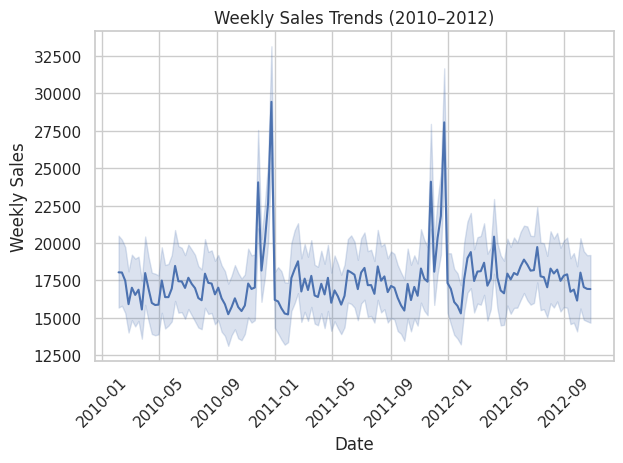

In [21]:
sns.lineplot(data=df,x='Date',y='Weekly_Sales')
plt.title("Weekly Sales Trends (2010–2012)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

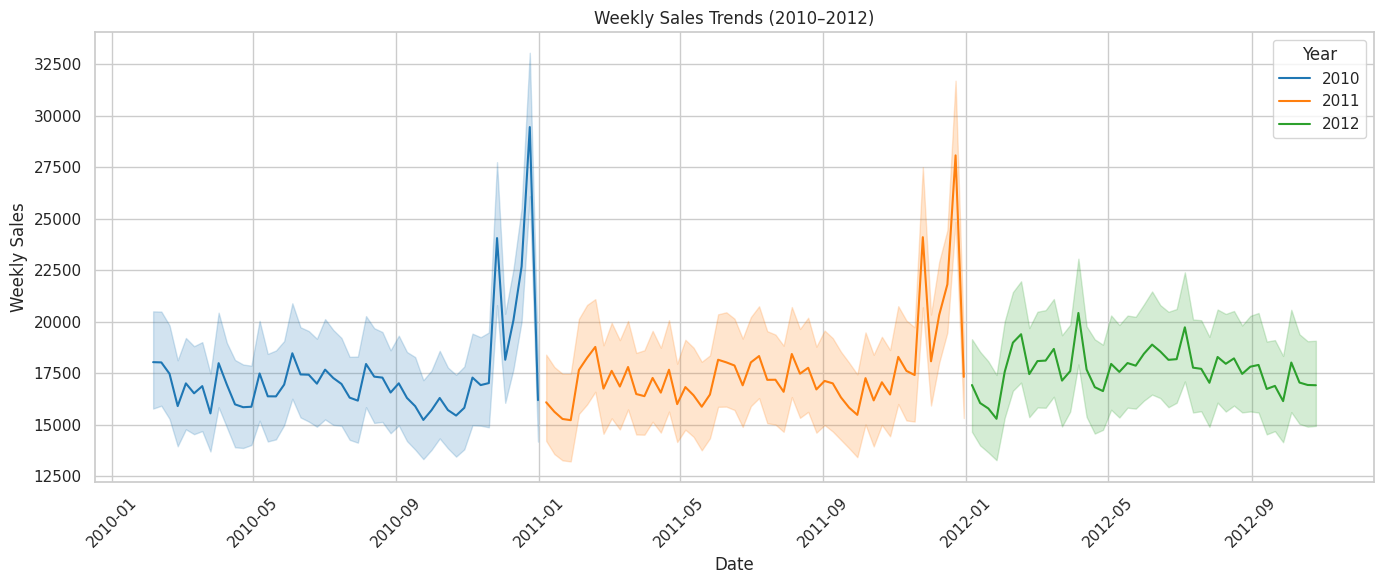

In [22]:
filtered_df = df[df['Year'].isin([2010, 2011, 2012])]

# Plot all years on one chart
plt.figure(figsize=(14, 6))
sns.lineplot(data=filtered_df,x='Date',y='Weekly_Sales',hue='Year', palette='tab10')
plt.title("Weekly Sales Trends (2010–2012)")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()

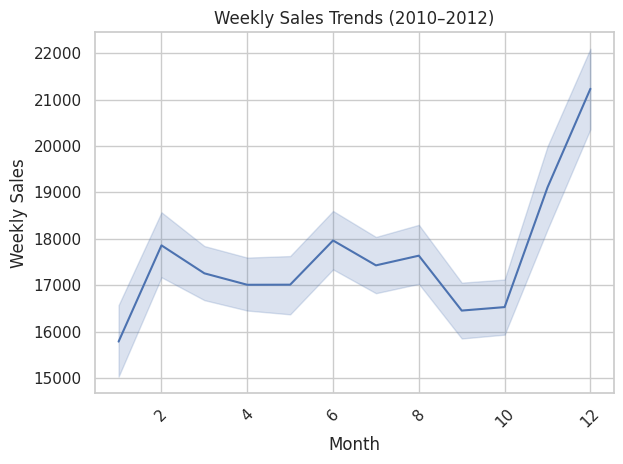

In [23]:
sns.lineplot(data=df,x='Month',y='Weekly_Sales')
plt.title("Weekly Sales Trends (2010–2012)")
plt.xlabel("Month")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

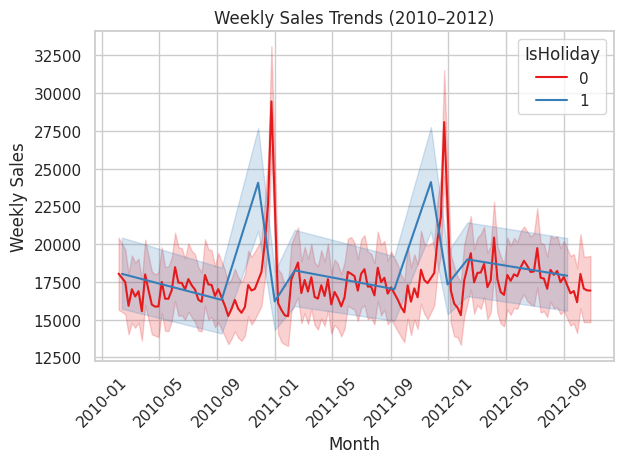

In [24]:
sns.lineplot(data=df, x='Date', y='Weekly_Sales', hue='IsHoliday', palette='Set1')
plt.title("Weekly Sales Trends (2010–2012)")
plt.xlabel("Month")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

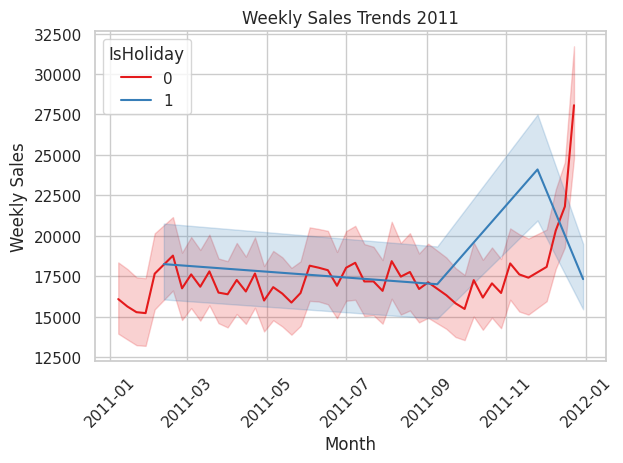

In [25]:
sns.lineplot(data=df.loc[df.Year==2011], x='Date', y='Weekly_Sales', hue='IsHoliday', palette='Set1')
plt.title("Weekly Sales Trends 2011")
plt.xlabel("Month")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Features

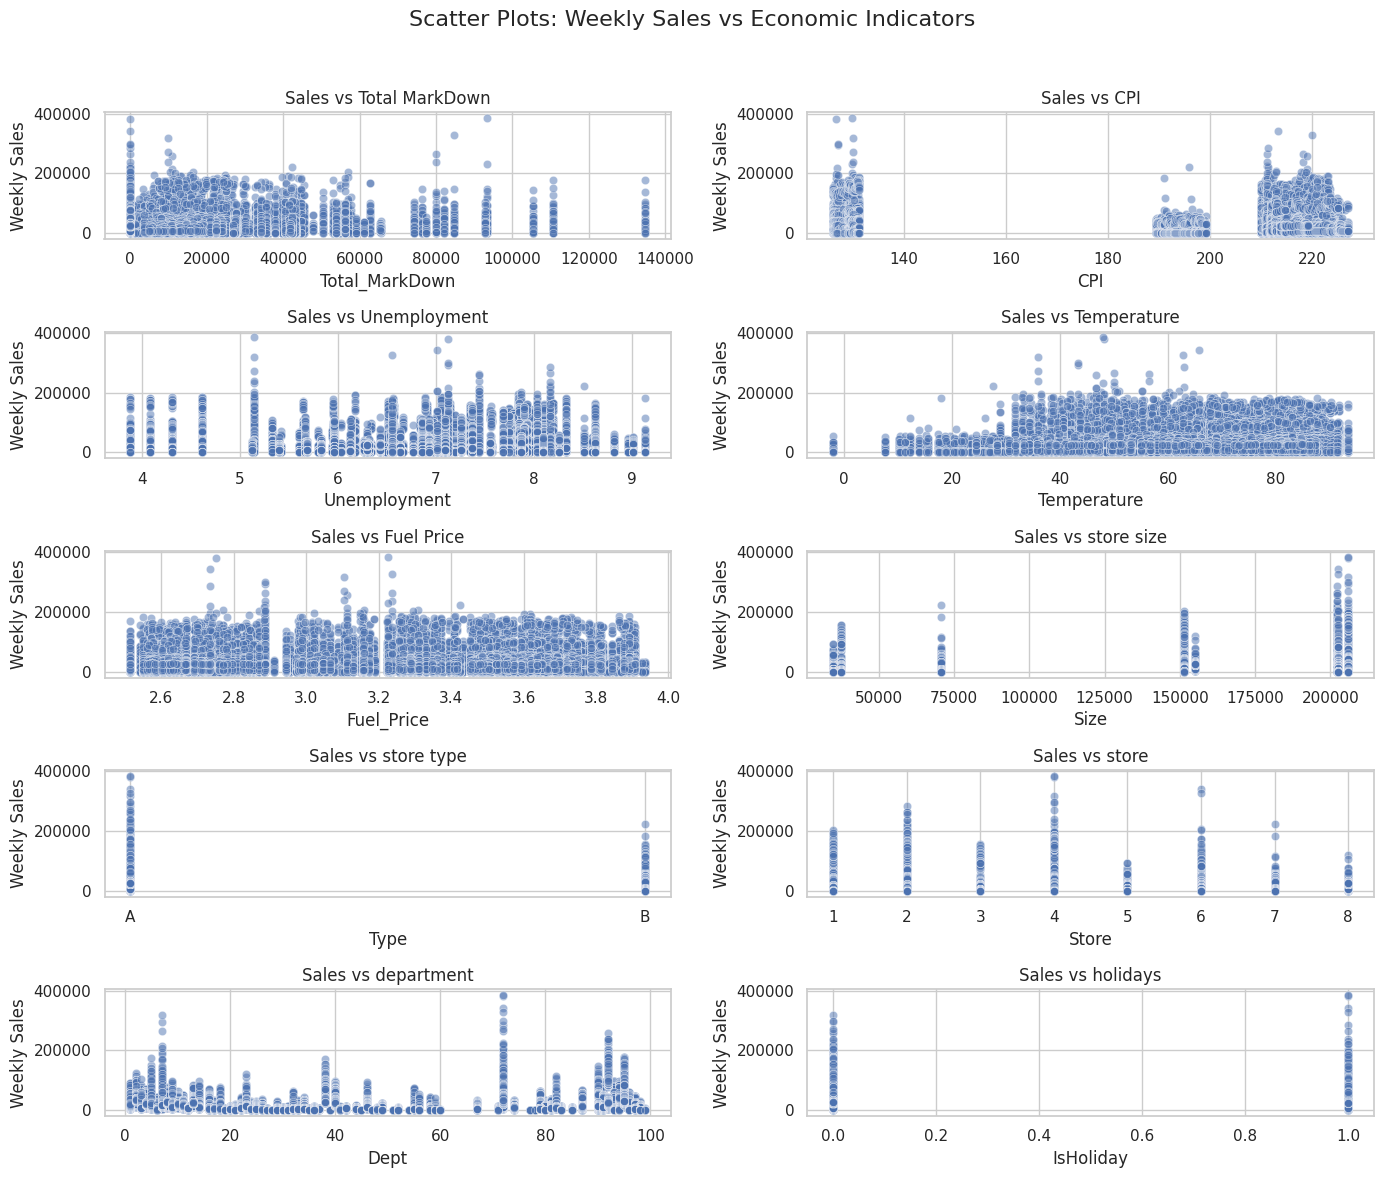

In [26]:
# Set plot style
sns.set(style="whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
fig.suptitle("Scatter Plots: Weekly Sales vs Economic Indicators", fontsize=16)

# Define pairs to plot
pairs = [
    ('Total_MarkDown', 'Sales vs Total MarkDown'),
    ('CPI', 'Sales vs CPI'),
    ('Unemployment', 'Sales vs Unemployment'),
    ('Temperature', 'Sales vs Temperature'),
    ('Fuel_Price', 'Sales vs Fuel Price'),
    ('Size', 'Sales vs store size'),
    ('Type', 'Sales vs store type'),
    ('Store', 'Sales vs store'),
    ('Dept', 'Sales vs department'),
    ('IsHoliday', 'Sales vs holidays'),

]

# Plot each pair
for ax, (feature, title) in zip(axes.flat, pairs):
    sns.scatterplot(data=df, x=feature, y='Weekly_Sales', ax=ax, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel('Weekly Sales')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Direct Relationship:**

1.   CPI and Sales
2.   Store size and Sales
3.   Type and Sales
4.   Holidays and Sales

**Inverse Relationship:**

1.   MarksDown and Sales
2.   Unemployment and Sales

**No Relations At All:**

1.   Tempretuer and Sales
2.   Fuel and Sales

**Unclear Relations:**

1. Sales vs. Store
2. Sales vs. Department

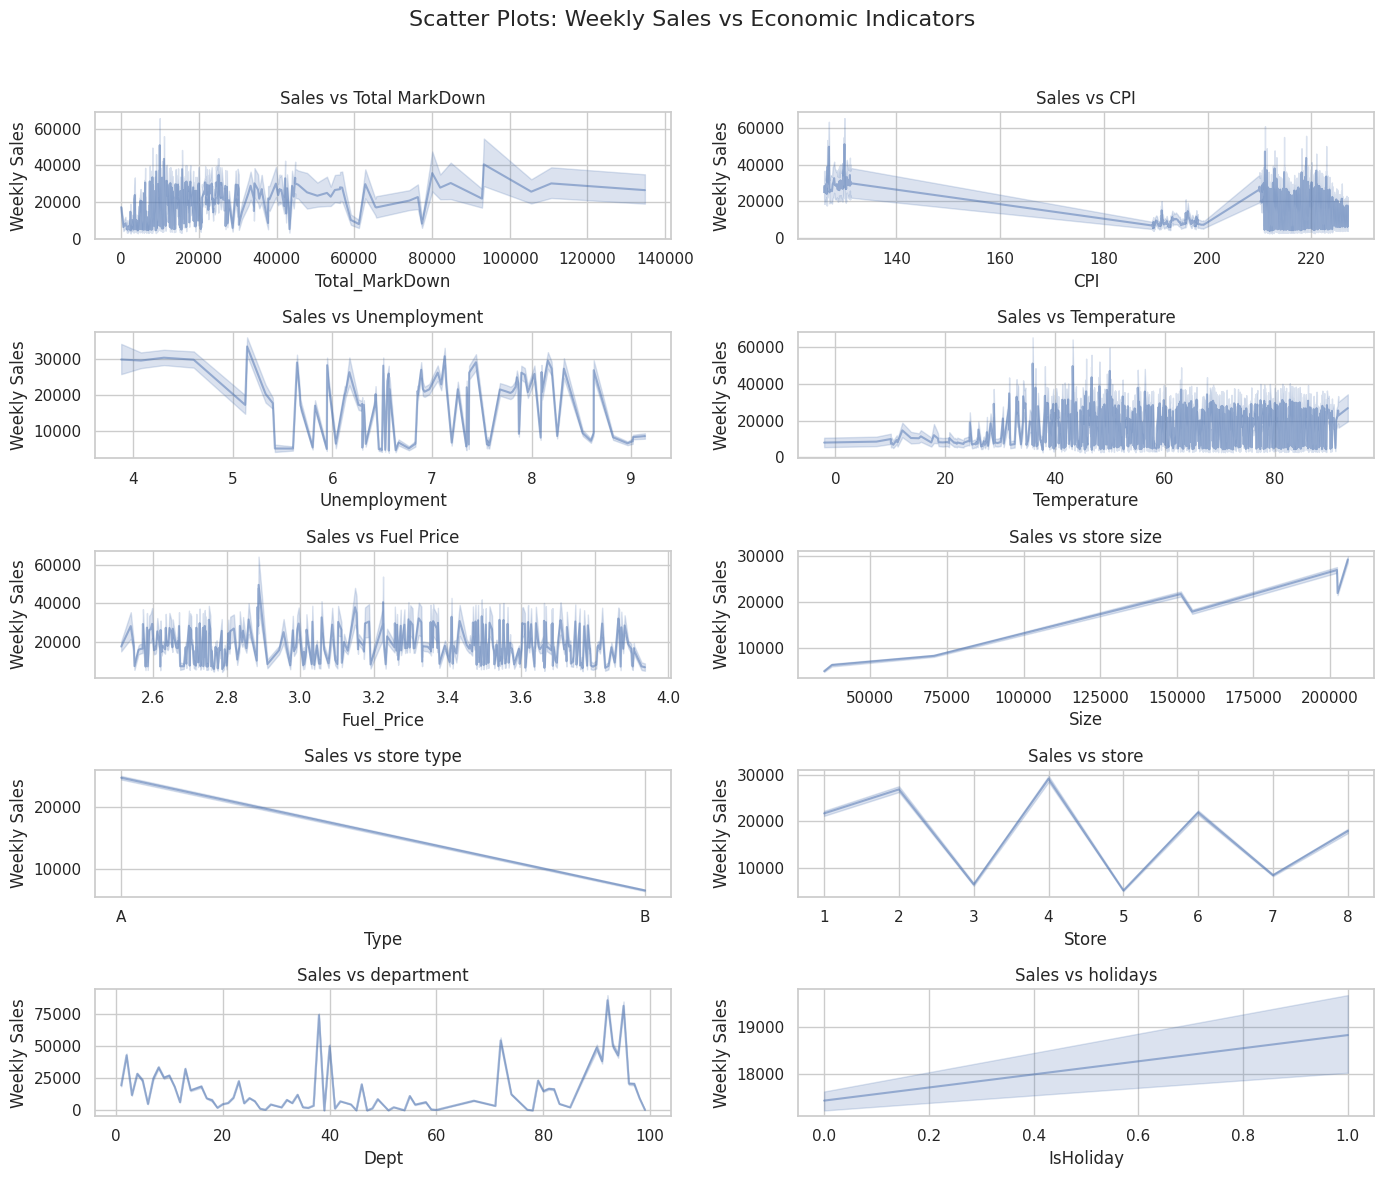

In [27]:
# Set plot style
sns.set(style="whitegrid")

# Create figure with subplots
fig, axes = plt.subplots(5, 2, figsize=(14, 12))
fig.suptitle("Scatter Plots: Weekly Sales vs Economic Indicators", fontsize=16)

# Define pairs to plot
pairs = [
    ('Total_MarkDown', 'Sales vs Total MarkDown'),
    ('CPI', 'Sales vs CPI'),
    ('Unemployment', 'Sales vs Unemployment'),
    ('Temperature', 'Sales vs Temperature'),
    ('Fuel_Price', 'Sales vs Fuel Price'),
    ('Size', 'Sales vs store size'),
    ('Type', 'Sales vs store type'),
    ('Store', 'Sales vs store'),
    ('Dept', 'Sales vs department'),
    ('IsHoliday', 'Sales vs holidays'),

]

# Plot each pair
for ax, (feature, title) in zip(axes.flat, pairs):
    sns.lineplot(data=df, x=feature, y='Weekly_Sales', ax=ax, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel('Weekly Sales')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Fuel price has a Direct relationship with sales

#### Departments

In [28]:
depts=df.groupby('Dept')[['Store','Size','Type','Weekly_Sales']].value_counts().reset_index().sort_values(by='Weekly_Sales',ascending=False)
depts

Dept  Store    Size Type  Weekly_Sales  count
52992    72      4  205863    A     385051.04      1
52991    72      4  205863    A     381072.11      1
53278    72      6  202505    A     342578.65      1
53277    72      6  202505    A     326866.60      1
7435      7      4  205863    A     318422.01      1
...     ...    ...     ...  ...           ...    ...
43205    47      6  202505    A       -698.00      1
43147    47      1  151315    A       -863.00      1
43185    47      4  205863    A       -898.00      1
31640    32      3   37392    B      -1008.96      1
43138    47      2  202307    A      -1098.00      3

[69290 rows x 6 columns]

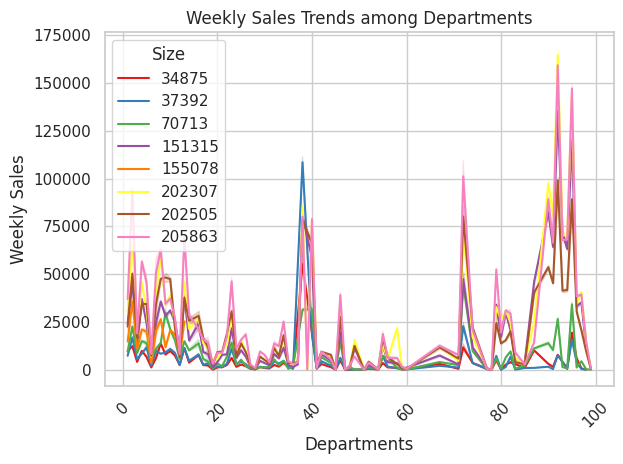

In [29]:
sns.lineplot(data=depts, x='Dept', y='Weekly_Sales', hue='Size', palette='Set1')
plt.title("Weekly Sales Trends among Departments")
plt.xlabel("Departments")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

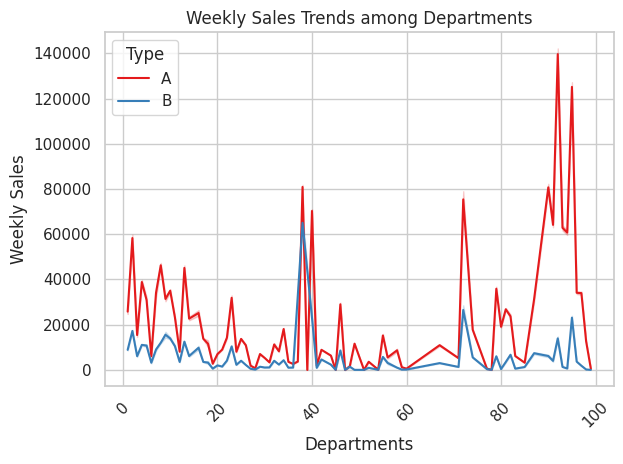

In [30]:
sns.lineplot(data=depts, x='Dept', y='Weekly_Sales', hue='Type', palette='Set1')
plt.title("Weekly Sales Trends among Departments")
plt.xlabel("Departments")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
df.groupby('Type')['Dept'].value_counts()

Type  Dept
A     1       715
      2       715
      3       715
      4       715
      5       715
             ... 
B     48       83
      47       35
      77        9
      78        3
      99        1
Name: count, Length: 154, dtype: int64

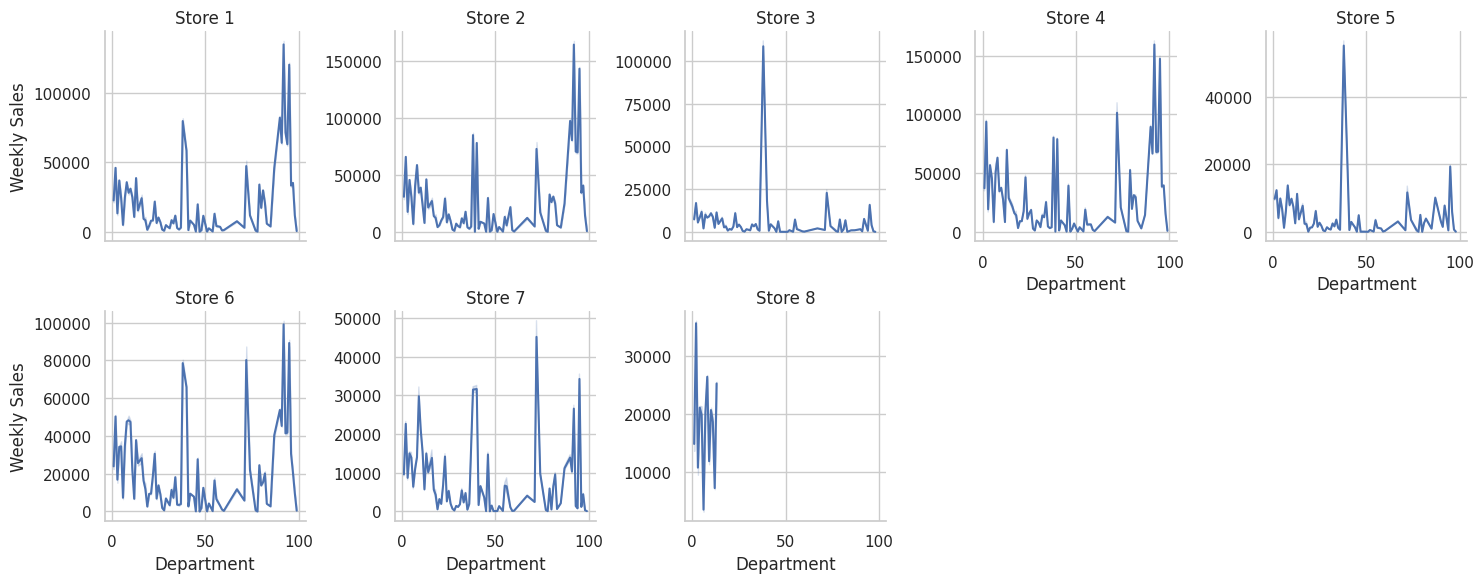

In [32]:
g = sns.FacetGrid(depts, col='Store', col_wrap=5, height=3, sharey=False)
g.map(sns.lineplot, 'Dept', 'Weekly_Sales')
g.set_titles("Store {col_name}")
g.set_axis_labels("Department", "Weekly Sales")
plt.tight_layout()
plt.show()


In [33]:
df.groupby('Store')['Dept'].value_counts()

Store  Dept
1      1       143
       2       143
       3       143
       4       143
       5       143
              ... 
8      9       143
       10      143
       11      143
       12      143
       13       84
Name: count, Length: 543, dtype: int64

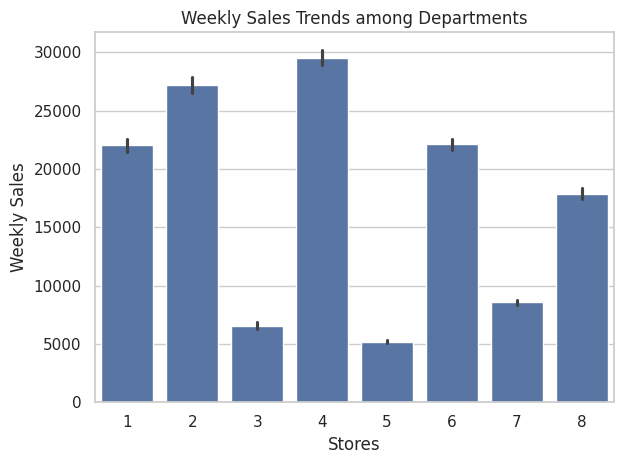

In [34]:
sns.barplot(data=depts, x='Store', y='Weekly_Sales')
plt.title("Weekly Sales Trends among Departments")
plt.xlabel("Stores")
plt.ylabel("Weekly Sales")
plt.tight_layout()
plt.show()

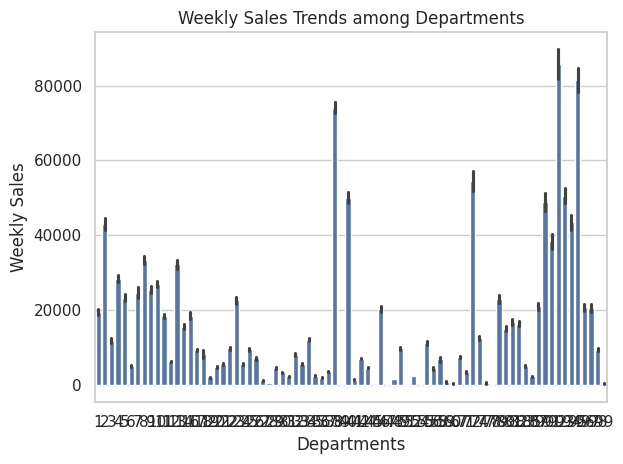

In [35]:
sns.barplot(data=depts, x='Dept', y='Weekly_Sales')
plt.title("Weekly Sales Trends among Departments")
plt.xlabel("Departments")
plt.ylabel("Weekly Sales")
plt.tight_layout()
plt.show()

In [36]:
dept_avg=df.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).reset_index()
dept_avg

Dept  Weekly_Sales
0     92  85792.497323
1     95  81442.913367
2     38  74140.333506
3     72  54470.710579
4     93  50556.830378
..   ...           ...
73    45     24.470191
74    51     19.091436
75    78      8.783529
76    39      2.184000
77    47    -18.513182

[78 rows x 2 columns]

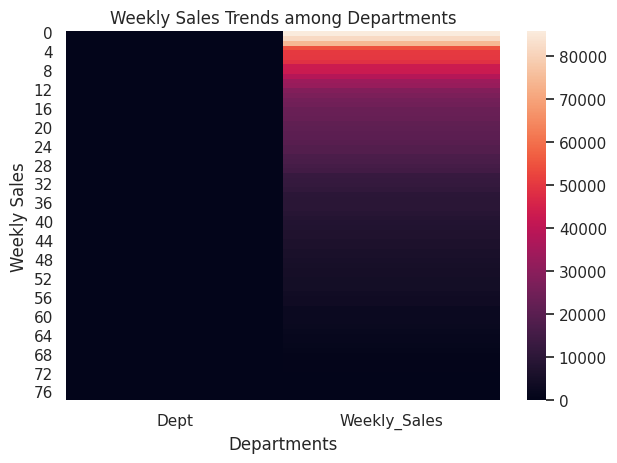

In [37]:
sns.heatmap(data=dept_avg)
plt.title("Weekly Sales Trends among Departments")
plt.xlabel("Departments")
plt.ylabel("Weekly Sales")
plt.tight_layout()
plt.show()

### Dive Deeper

<Axes: xlabel='Week'>

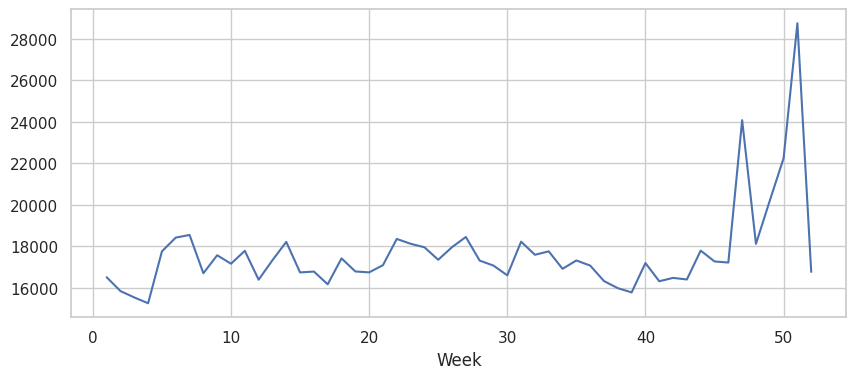

In [38]:
df.groupby('Week')['Weekly_Sales'].mean().plot(figsize=(10,4))


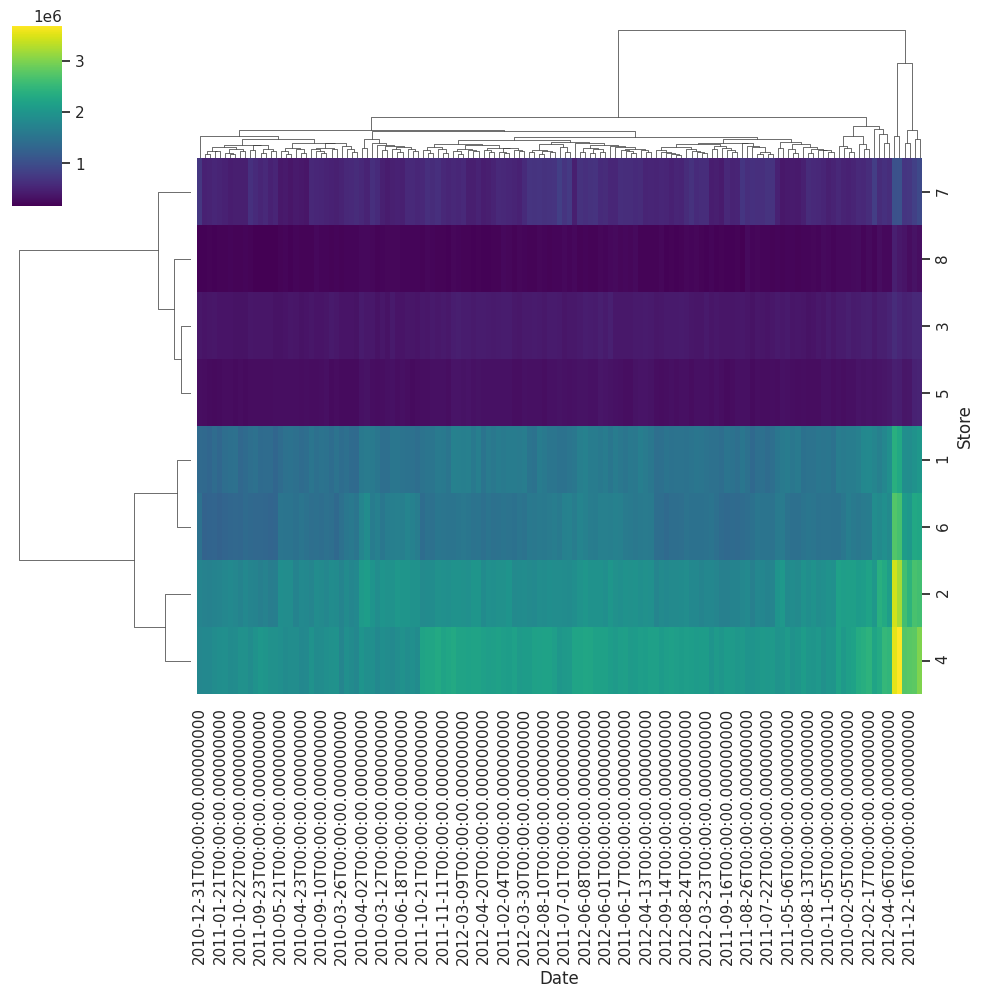

In [39]:
store_sales = df.groupby(['Store','Date'])['Weekly_Sales'].sum().unstack()
sns.clustermap(store_sales.fillna(0), cmap="viridis")

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


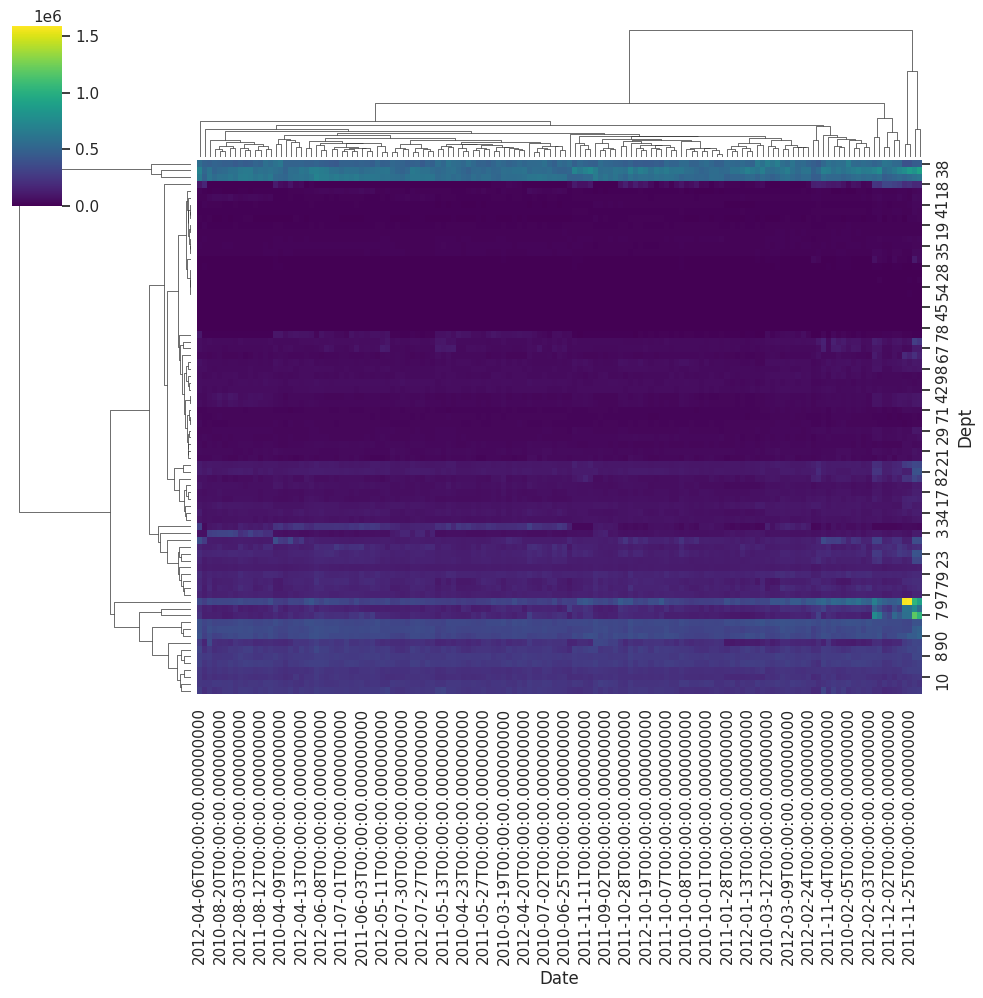

In [40]:
store_sales = df.groupby(['Dept','Date'])['Weekly_Sales'].sum().unstack()
sns.clustermap(store_sales.fillna(0), cmap="viridis")


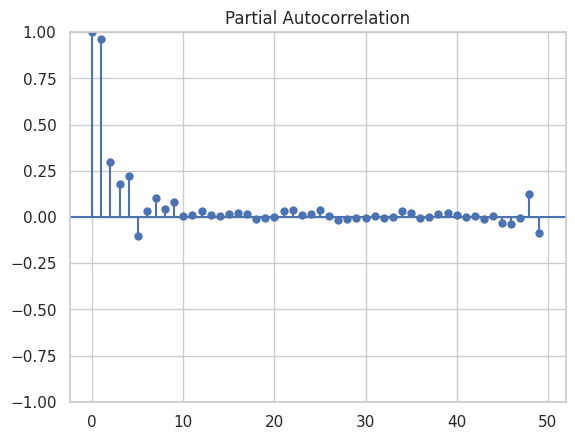

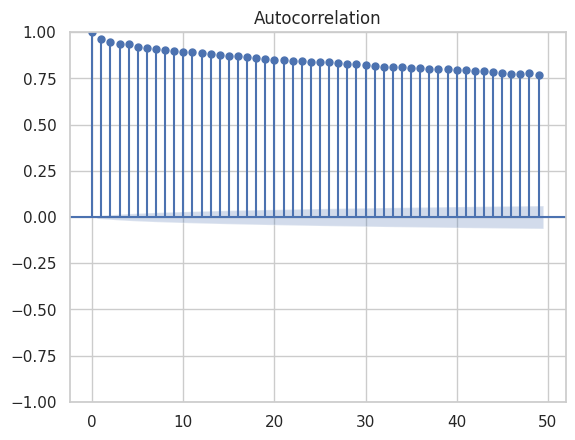

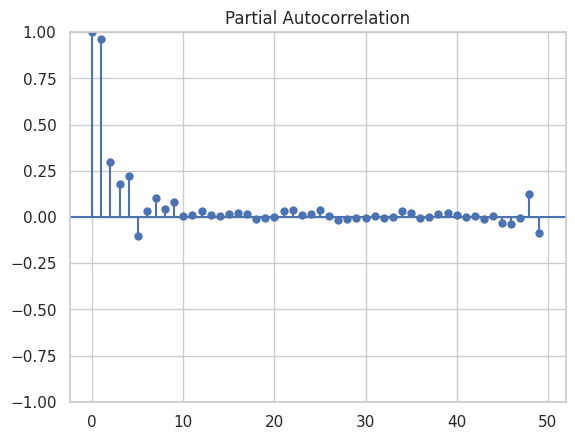

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Weekly_Sales'])
plot_pacf(df['Weekly_Sales'])

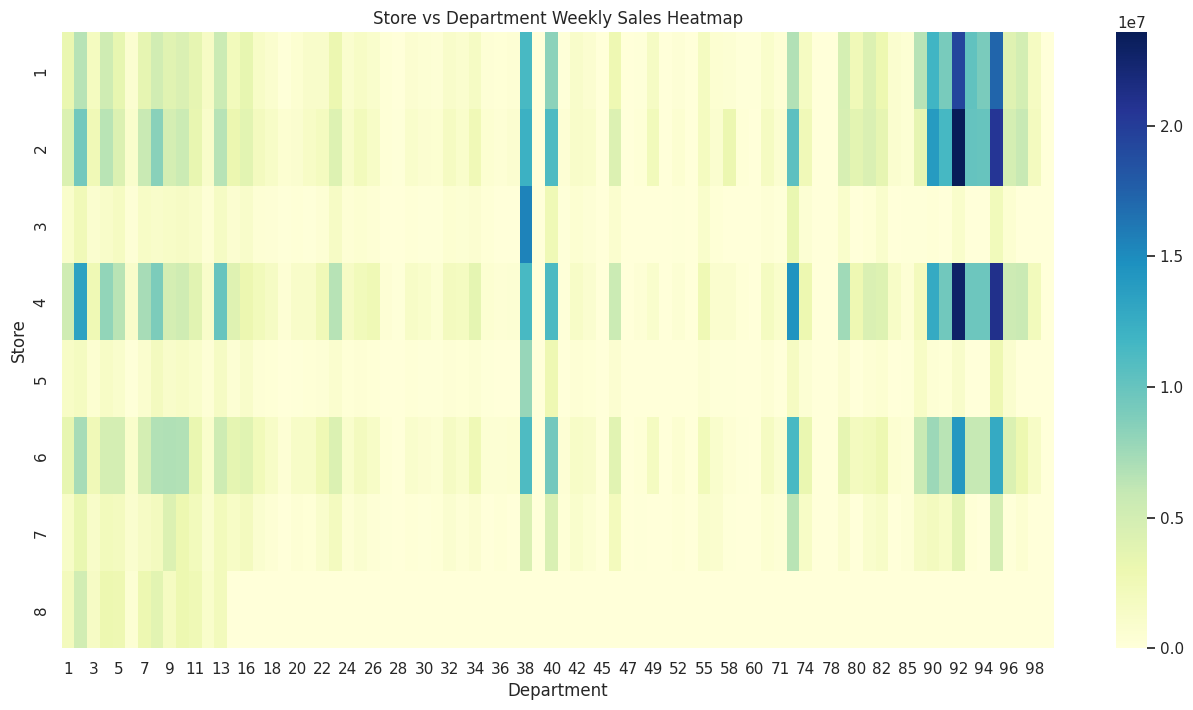

In [42]:
# Pivot table: sum of weekly sales by Store and Dept
pivot = df.pivot_table(index='Store', columns='Dept', values='Weekly_Sales', aggfunc='sum', fill_value=0)

plt.figure(figsize=(16, 8))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title("Store vs Department Weekly Sales Heatmap")
plt.xlabel("Department")
plt.ylabel("Store")
plt.show()


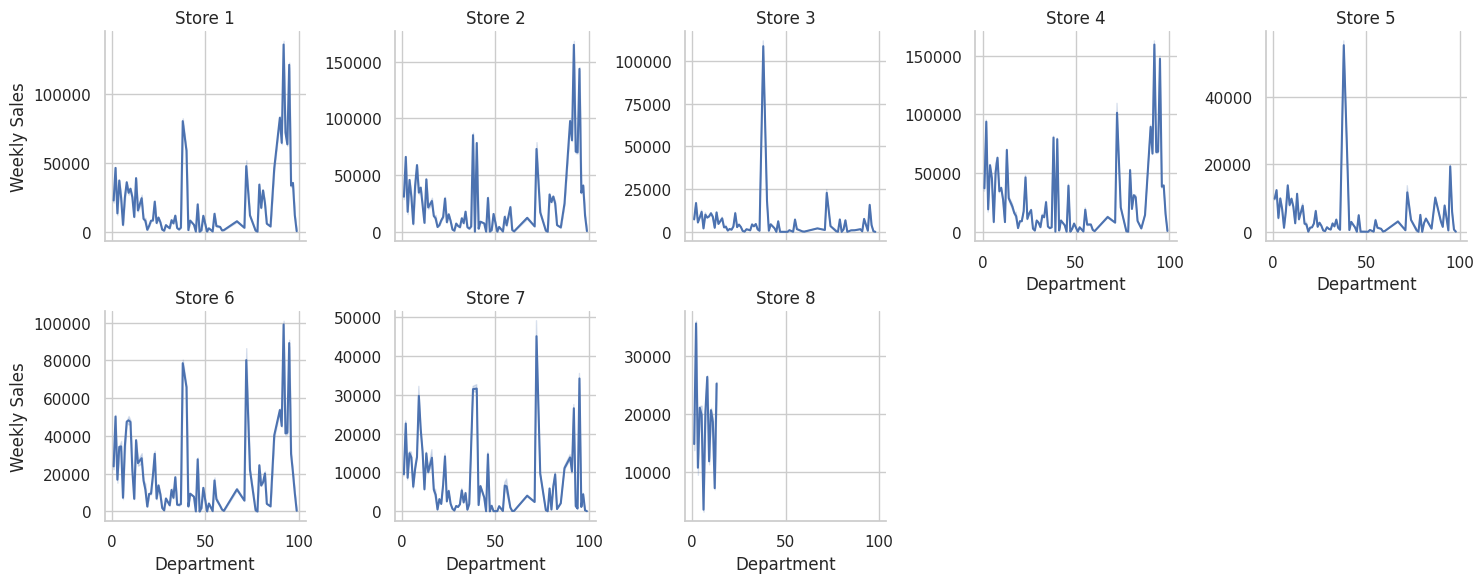

In [43]:
g = sns.FacetGrid(df, col='Store', col_wrap=5, height=3, sharey=False)
g.map(sns.lineplot, 'Dept', 'Weekly_Sales')
g.set_titles("Store {col_name}")
g.set_axis_labels("Department", "Weekly Sales")
plt.tight_layout()
plt.show()


In [46]:
# Add season feature
df['Season'] = df['Month']%12 // 3
season_map = {0:'Winter', 1:'Spring', 2:'Summer', 3:'Fall'}
df['Season'] = df['Season'].map(season_map)

# Aggregate markdowns by store type and season
df.groupby(['Type','Season'])['Total_MarkDown'].mean().reset_index()


Type  Season  Total_MarkDown
0    A    Fall     7103.388018
1    A  Spring     6011.580214
2    A  Summer     7784.020979
3    A  Winter    15284.921161
4    B    Fall     2764.550965
5    B  Spring     2858.323881
6    B  Summer     2838.669131
7    B  Winter     5951.932523

In [47]:
# Create lag features (shift by 1 week)
df = df.sort_values(['Store','Dept','Date'])
df['Weekly_Sales_lag1'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(1)
df['CPI_lag1'] = df.groupby('Store')['CPI'].shift(1)
df['Fuel_Price_lag1'] = df.groupby('Store')['Fuel_Price'].shift(1)
# These lag features allow models to learn from previous week’s conditions.

In [48]:
df.head(10)

Store  Dept       Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2010-02-05      24924.50        42.31       2.572        0.0   
1      1     1 2010-02-12      46039.49        38.51       2.548        0.0   
2      1     1 2010-02-19      41595.55        39.93       2.514        0.0   
3      1     1 2010-02-26      19403.54        46.63       2.561        0.0   
4      1     1 2010-03-05      21827.90        46.50       2.625        0.0   
5      1     1 2010-03-12      21043.39        57.79       2.667        0.0   
6      1     1 2010-03-19      22136.64        54.58       2.720        0.0   
7      1     1 2010-03-26      26229.21        51.45       2.732        0.0   
8      1     1 2010-04-02      57258.43        62.27       2.719        0.0   
9      1     1 2010-04-09      42960.91        65.86       2.770        0.0   

   MarkDown2  MarkDown3  MarkDown4  ...    Size  Month  Year Week  IsHoliday  \
0        0.0        0.0        0.0  ...  151315      2  2010    5          0   
1        0.0        0.0        0.0  ...  151315      2  2010    6          1   
2        0.0        0.0        0.0  ...  151315      2  2010    7          0   
3        0.0        0.0        0.0  ...  151315      2  2010    8          0   
4        0.0        0.0        0.0  ...  151315      3  2010    9          0   
5        0.0        0.0        0.0  ...  151315      3  2010   10          0   
6        0.0        0.0        0.0  ...  151315      3  2010   11          0   
7        0.0        0.0        0.0  ...  151315      3  2010   12          0   
8        0.0        0.0        0.0  ...  151315      4  2010   13          0   
9        0.0        0.0        0.0  ...  151315      4  2010   14          0   

   Total_MarkDown  Season  Weekly_Sales_lag1    CPI_lag1  Fuel_Price_lag1  
0             0.0  Winter                NaN         NaN              NaN  
1             0.0  Winter           24924.50  211.096358            2.572  
2             0.0  Winter           46039.49  211.242170            2.548  
3             0.0  Winter           41595.55  211.289143            2.514  
4             0.0  Spring           19403.54  211.319643            2.561  
5             0.0  Spring           21827.90  211.350143            2.625  
6             0.0  Spring           21043.39  211.380643            2.667  
7             0.0  Spring           22136.64  211.215635            2.720  
8             0.0  Spring           26229.21  211.018042            2.732  
9             0.0  Spring           57258.43  210.820450            2.719  

[10 rows x 24 columns]

In [49]:
# Save DataFrame to CSV
df.to_csv("walmart_cleaned.csv", index=False)

# Download the file
from google.colab import files
files.download("walmart_cleaned.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>